In [14]:
#things to be import

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.autograd as atgd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [15]:
#loading training and testing data

batchsize = 16
Trainsize = 10000
Testsize = 10000

transform = transforms.Compose(
    [
    transforms.Resize((32,32)),    
    transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.MNIST(root = './data/mnist', 
                           train = True, 
                           transform = transform,
                           download = True) 
test_dataset = torchvision.datasets.MNIST(root = './data/mnist',
                           train = False,
                           transform = transform,
                           download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)

print("The number of training images: ", Trainsize)
print("The number of testing images: ", Testsize)
print("Data load OK!")

The number of training images:  10000
The number of testing images:  10000
Data load OK!


In [16]:
#Network structure

# # linear classifier
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(32*32, 10)
#     def forward(self, x):
#         x = x.view(-1, 32 * 32)
#         x= self.fc1(x)  
#         return x

# # Network with only fc layers 
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(32*32, 16*16)
#         self.fc2 = nn.Linear(16*16, 8*8)
#         self.fc3 = nn.Linear(8*8, 10)

#     def forward(self, x):
#         x = x.view(-1, 32 * 32)
#         x = func.relu(self.fc1(x))
#         x = func.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# Network with 2 Conv2, 3fc
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 10)
        
    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)

        return x


# # Network with 2 Conv2, 3fc
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(func.relu(self.conv1(x)))
#         x = self.pool(func.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = func.relu(self.fc1(x))
#         x = func.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

net = Net()
net = net.cuda()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=10, bias=True)
)


In [17]:
#training process

epoch_num = 5
x1 = range(1,epoch_num+1)
x2 = range(1,epoch_num+1)
accuracy1 = []
accuracy2 = []
loss1 = []
loss2 = []

for epoch in range(epoch_num): 
    for i, data in enumerate(train_loader, 0):
        
        if i >= Trainsize/batchsize:
            break        
        inputs, labels = data  
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()     
        outputs = net(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

    # training accuracy and loss
    print("epoch number %d" % (epoch + 1))
    
    correct = 0
    total = 0
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        if i >= Trainsize/batchsize:
            break
        
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        
        train_loss = criterion(outputs, labels)
        running_loss += train_loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
       
    print('train_accuracy: %.3f %%' % (100 * correct / total))
    accuracy1.append(100 * correct / total)
    print("train_loss: %.3f" % (running_loss / (len(train_loader)*batchsize) ))
    loss1.append(running_loss / (len(train_loader)*batchsize))
    
    # testing accuracy and loss
    correct = 0
    total = 0
    running_loss = 0
    for i, data in enumerate(test_loader, 0):
        if i >= Testsize/batchsize:
            break
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
      
        
        test_loss = criterion(outputs, labels)
        running_loss += test_loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
       
    print('test_accuracy: %.3f %%' % (100 * correct / total))
    accuracy2.append(100 * correct / total)
    print("test_loss: %.3f" % (running_loss / (len(test_loader)*batchsize) ))
    loss2.append(running_loss / (len(test_loader)*batchsize))

print("Training OK!")


epoch number 1
train_accuracy: 88.840 %
train_loss: 0.004
test_accuracy: 89.370 %
test_loss: 0.022
epoch number 2
train_accuracy: 92.060 %
train_loss: 0.003
test_accuracy: 92.580 %
test_loss: 0.015
epoch number 3
train_accuracy: 94.010 %
train_loss: 0.002
test_accuracy: 94.780 %
test_loss: 0.011
epoch number 4
train_accuracy: 95.430 %
train_loss: 0.002
test_accuracy: 95.640 %
test_loss: 0.009
epoch number 5
train_accuracy: 96.000 %
train_loss: 0.001
test_accuracy: 96.440 %
test_loss: 0.008
Training OK!


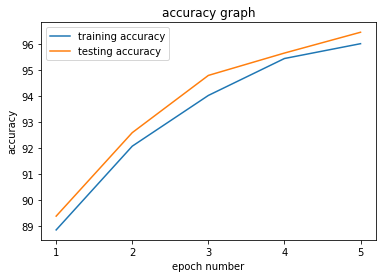

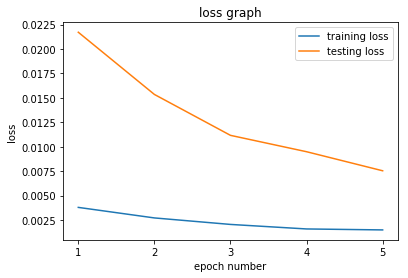

In [18]:
# visualize the result

plt.plot(x1, accuracy1, label="training accuracy")
plt.plot(x2, accuracy2, label="testing accuracy")
plt.xlabel("epoch number")
plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("accuracy")
plt.title("accuracy graph")
plt.legend()
plt.show()


plt.plot(x1, loss1, label="training loss")
plt.plot(x2, loss2, label="testing loss")
plt.xlabel("epoch number")
plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("loss")
plt.title("loss graph")
plt.legend()
plt.show()


In [19]:
# the acc for different numbers 

single_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)
correct = [0.0]*10
total = [0.0]*10
for data in single_loader:
    images, labels = data 
    images = images.cuda()
    labels = labels.cuda()
    
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total[labels] += 1
    correct[labels] += (predicted == labels).sum().item()  
    
num_acc = []
for i in range(10):
    num_acc.append(100*correct[i]  / total[i])
    print("test_acc: %.3f" % (100*correct[i]  / total[i]))

test_acc: 98.673
test_acc: 98.855
test_acc: 95.930
test_acc: 96.337
test_acc: 95.825
test_acc: 94.731
test_acc: 97.390
test_acc: 94.942
test_acc: 95.688
test_acc: 95.639


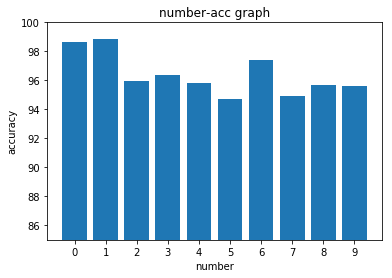

In [20]:
#visualize the result

num = range(0,10)
plt.bar(num, num_acc)

plt.xlabel("number")
plt.ylim((85,100))
plt.xticks(np.linspace(0,9,10))
plt.ylabel("accuracy")
plt.title("number-acc graph")

plt.show()

ground truth:  7 predicted result:  2


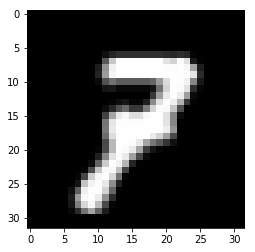

In [21]:
# find incorrect detection result

single_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)


for data in single_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    
    
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    
    if predicted != labels:
        plt.imshow(images.squeeze(), cmap = "gray")
        print("ground truth: ", labels.item(), "predicted result: ", predicted.item())
        break
        

    


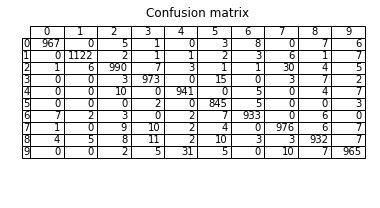

In [22]:
# output the confusion matrix 

single_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)
cells = [([0]*10)for i in range(10)]

for data in single_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    cells[predicted.item()][labels.item()] += 1


labels_num = [i for i in range(10)]
predicted_num = [i for i in range(10)]


plt.subplot2grid((4,3), (0,0), colspan=5, rowspan=3)
plt.axis("off")
plt.table(rowLabels = predicted_num, colLabels = labels_num ,cellText = cells,loc="upper center",
         colWidths= [0.1]*10)
plt.title("Confusion matrix")
plt.show()
